### IMPORTS & CONFIGURATION

In [68]:
# ================== IMPORTS & CONFIGURATION ==================
import os
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, TimeDistributed, Add, MultiHeadAttention
from keras.models import load_model


### DATA PREPROCESSING

In [69]:
def load_and_preprocess_data(filepath, feature_range=(-1, 1), replace_nan=True):
    """Load and preprocess time series data with comprehensive cleaning and normalization"""
    df = pd.read_csv(filepath)
    if not np.issubdtype(df.iloc[:, 0].dtype, np.number):
        df_numeric = df.iloc[:, 1:]
        time_column = df.iloc[:, 0]
    else:
        df_numeric = df.copy()
        time_column = None
    
    data = df_numeric.values
    
    if replace_nan:
        data_reshaped = data.reshape(-1, df_numeric.shape[1])
        for i in range(data_reshaped.shape[1]):
            col = data_reshaped[:, i]
            col_mean = np.nanmean(col[np.isfinite(col)])
            col[~np.isfinite(col)] = col_mean if not np.isnan(col_mean) else 0
            data_reshaped[:, i] = col
        data = data_reshaped.reshape(data.shape)
    
    scaler = MinMaxScaler(feature_range=feature_range)
    original_shape = data.shape
    if len(original_shape) > 2:
        data = data.reshape(-1, original_shape[-1])
    
    data_scaled = scaler.fit_transform(data)
    
    if len(original_shape) > 2:
        data_scaled = data_scaled.reshape(original_shape)
    
    if not np.all(np.isfinite(data_scaled)):
        nan_count = np.sum(~np.isfinite(data_scaled))
        print(f"⚠️ Warning: {nan_count} NaN/Inf values remain after preprocessing")
    
    return data_scaled, df_numeric.columns.tolist(), scaler, time_column

### ARIMA MODELING

In [70]:
# ================== ARIMA MODELING FUNCTION ==================
# def make_stationary_and_fit_arima(data, columns):
#     arima_models = []
#     residuals = []
#     orders = []
    
#     for i in range(data.shape[1]):
#         series = pd.Series(data[:, i], name=columns[i])
        
#         # Handle NaN values - forward fill then drop any remaining
#         series = series.ffill().dropna()
        
#         if len(series) < 10:  # Skip if not enough data
#             print(f"Skipping {columns[i]} - insufficient data after cleaning")
#             arima_models.append(None)
#             residuals.append(np.zeros(data.shape[0]))  # Placeholder
#             orders.append((0, 0, 0))
#             continue
            
#         try:
#             # Stationarity check with error handling
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 result = adfuller(series)
#                 p_value = result[1]
                
#             if p_value > 0.05:
#                 stationary_series = series.diff().dropna()
#                 if len(stationary_series) < 5:  # Check if differencing left too few points
#                     stationary_series = series.copy()  # Fall back to original
#             else:
#                 stationary_series = series.copy()
                
#             # ARIMA fitting with more robust error handling
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 model = auto_arima(
#                     stationary_series,
#                     seasonal=False,
#                     suppress_warnings=True,
#                     error_action='ignore',
#                     maxiter=50,
#                     n_fits=10
#                 )
                
#             # Get residuals safely
#             try:
#                 pred = model.predict_in_sample()
#                 aligned_series = stationary_series[-len(pred):]
#                 res = aligned_series - pred
#             except:
#                 res = np.zeros(len(stationary_series))
                
#             # Pad residuals to match original length
#             padded_res = np.zeros(data.shape[0])
#             padded_res[-len(res):] = res
                
#             arima_models.append(model)
#             residuals.append(padded_res)
#             orders.append(model.order)
            
#         except Exception as e:
#             print(f"Failed on {columns[i]}: {str(e)}")
#             arima_models.append(None)
#             residuals.append(np.zeros(data.shape[0]))
#             orders.append((0, 0, 0))
    
#     # Convert to numpy array and trim
#     residuals = np.array(residuals).T
#     min_len = min(len(r[r != 0]) for r in residuals.T)  # Find first non-zero
#     residuals = np.array([r[-min_len:] for r in residuals.T]).T
    
#     return arima_models, residuals, orders

### TIME-GAN IMPLEMENTATION

In [81]:
class TimeGAN(tf.keras.Model):
    def __init__(self, seq_len, n_features, latent_dim=64):
        super(TimeGAN, self).__init__()

        self.custom_metrics = {
            'gen_loss': [],
            'disc_loss': [],
            'sup_loss': [],
            'disc_accuracy': [],
            'best_loss': float('inf')
        }

        self.seq_len = seq_len
        self.n_features = n_features
        self.latent_dim = latent_dim

        # Best trial hyperparameters
        self.gen_rnn_units = 16
        self.gen_dense_units = 16
        self.gen_dropout = 0.4898095069332775
        self.disc_gru_units = 64
        self.disc_dense_units = 16
        self.disc_dropout = 0.2267642157070863
        self.disc_l2 = 0.0033253741041475776
        self.sup_lstm1 = 64
        self.sup_lstm2 = 16

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.supervisor = self.build_supervisor()
        self.recovery = self.build_recovery()

    def build_generator(self):
        inputs = Input(shape=(None, self.n_features))
        x = SimpleRNN(self.gen_rnn_units, return_sequences=True, kernel_initializer='orthogonal')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(self.gen_dropout)(x)
        x = Dense(self.gen_dense_units, activation='tanh')(x)
        outputs = TimeDistributed(Dense(self.n_features, activation='tanh', kernel_initializer='glorot_normal'))(x)
        return Model(inputs, outputs, name="Generator")

    def build_discriminator(self):
        inputs = Input(shape=(None, self.n_features))
        x = GRU(self.disc_gru_units, return_sequences=False, kernel_initializer='glorot_uniform')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(self.disc_dropout)(x)
        x = Dense(self.disc_dense_units, activation='relu', kernel_regularizer=l2(self.disc_l2))(x)
        outputs = Dense(1, activation='sigmoid')(x)
        return Model(inputs, outputs, name="Discriminator")

    def build_supervisor(self):
        inputs = Input(shape=(None, self.n_features))
        x = LSTM(self.sup_lstm1, return_sequences=True)(inputs)
        x = LSTM(self.sup_lstm2, return_sequences=True)(x)
        outputs = TimeDistributed(Dense(self.n_features))(x)
        return Model(inputs, outputs, name="Supervisor")

    def build_recovery(self):
        inputs = Input(shape=(None, self.n_features))
        x = GRU(64, return_sequences=True)(inputs)
        outputs = TimeDistributed(Dense(self.n_features))(x)
        return Model(inputs, outputs, name="Recovery")

    def compile(self, lr=1.0252418540753458e-5):
        self.generator_optimizer = Adam(lr)
        self.discriminator_optimizer = Adam(lr)
        self.supervisor_optimizer = Adam(lr)
        self.recovery_optimizer = Adam(lr)
        self.bce_loss = tf.keras.losses.BinaryCrossentropy()
        self.mse_loss = tf.keras.losses.MeanSquaredError()

    def train(self, data, epochs=27, batch_size=32, save_path='saved_models_timegan_with_arima'):
        os.makedirs(save_path, exist_ok=True)
        dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(1000).batch(batch_size)

        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            total_batches = tf.data.experimental.cardinality(dataset).numpy()

            # 初始化 tqdm 进度条
            pbar = tqdm(dataset, total=total_batches, desc="Training", unit="batch")

            for batch in pbar:
                with tf.GradientTape(persistent=True) as tape:
                    synthetic_batch = self.generator(batch, training=True)

                    pred = self.supervisor(batch[:, :-1], training=True)
                    sup_loss = self.mse_loss(batch[:, 1:], pred)

                    real_output = self.discriminator(batch, training=True)
                    fake_output = self.discriminator(synthetic_batch, training=True)
                    disc_loss = 0.5 * (self.bce_loss(tf.ones_like(real_output), real_output) +
                                    self.bce_loss(tf.zeros_like(fake_output), fake_output))

                    gen_loss = self.bce_loss(tf.ones_like(fake_output), fake_output)
                    total_loss = gen_loss + 0.5 * sup_loss

                gen_vars = self.generator.trainable_variables + self.supervisor.trainable_variables
                gen_grads = tape.gradient(total_loss, gen_vars)
                self.generator_optimizer.apply_gradients(zip(gen_grads, gen_vars))

                disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)
                self.discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

                self.custom_metrics['gen_loss'].append(gen_loss.numpy())
                self.custom_metrics['disc_loss'].append(disc_loss.numpy())
                self.custom_metrics['sup_loss'].append(sup_loss.numpy())
                self.custom_metrics['disc_accuracy'].append(tf.reduce_mean(
                    tf.cast(tf.concat([tf.round(real_output), tf.round(1 - fake_output)], axis=0), tf.float32)).numpy())

                # 更新 tqdm 显示信息
                pbar.set_postfix({
                    "GenLoss": f"{gen_loss.numpy():.4f}",
                    "DiscLoss": f"{disc_loss.numpy():.4f}",
                    "SupLoss": f"{sup_loss.numpy():.4f}"
                })


                current_loss = np.mean(self.custom_metrics['gen_loss'][-total_batches:])
                if current_loss < self.custom_metrics['best_loss']:
                    self.custom_metrics['best_loss'] = current_loss
                    self.generator.save_weights(os.path.join(save_path, 'generator.weights.h5'))
                    self.discriminator.save_weights(os.path.join(save_path, 'discriminator.weights.h5'))
                    self.supervisor.save_weights(os.path.join(save_path, 'supervisor.weights.h5'))
                    self.recovery.save_weights(os.path.join(save_path, 'recovery.weights.h5'))

                    print(f"Model improved (loss: {current_loss:.4f}), saving weights...")



### EVALUATION METRICS

In [73]:
import gc
import joblib
from statsmodels.tsa.arima.model import ARIMA
import os
import numpy as np
import pandas as pd

In [ ]:
class HybridARIMAGenerator:
    def __init__(self, timegan_model, save_dir='saved_hybrid_models'):
        self.timegan = timegan_model
        self.arima_models = []
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        
    def fit_arima(self, real_data, order=(1, 0, 1)):
        print("Fitting one ARIMA model per feature...")
        window_size = self.timegan.seq_len
        self.arima_models = []

        for i in range(real_data.shape[-1]):
            print(f"  Fitting ARIMA for feature {i+1}/{real_data.shape[-1]}...")
            series = pd.Series(real_data[-window_size:, i])

            try:
                model = ARIMA(series, order=order).fit()
                joblib.dump(model, os.path.join(self.save_dir, f'best_arima_feature_{i}.pkl'))
                self.arima_models.append([model])
                print(f"    AIC: {model.aic:.2f}")
                del model
                gc.collect()
            except Exception as e:
                print(f"    ERROR fitting ARIMA for feature {i}: {e}")
                self.arima_models.append([None])
                
    def generate_hybrid_samples(self, n_samples=100):
        print("\nGenerating hybrid samples...")
        synthetic_samples = []

        # Load best ARIMA models
        best_arima_models = []
        for i in range(len(self.arima_models)):
            model_path = os.path.join(self.save_dir, f'best_arima_feature_{i}.pkl')
            if os.path.exists(model_path):
                best_arima_models.append(joblib.load(model_path))
            else:
                best_arima_models.append(None)

        for _ in tqdm(range(n_samples)):
            arima_series = []
            for i, models in enumerate(self.arima_models):
                model = best_arima_models[i] if best_arima_models[i] else np.random.choice([m for m in models if m is not None])
                forecast = model.forecast(steps=self.timegan.seq_len)
                arima_series.append(forecast.values)

            arima_series = np.stack(arima_series, axis=1)  # shape: (seq_len, n_features_arima)

            # === Correct Generator Input Shape ===
            input_dim = self.timegan.generator.input_shape[-1]  # likely 3
            fake_input = np.random.normal(size=(1, self.timegan.seq_len, input_dim))
            gan_residuals = self.timegan.generator(fake_input).numpy()[0]  # shape: (seq_len, input_dim)

            # === Combine only first N dimensions ===
            n_common = min(arima_series.shape[1], gan_residuals.shape[1])
            synthetic = arima_series[:, :n_common] * 0.7 + gan_residuals[:, :n_common] * 0.3

            synthetic_samples.append(synthetic)

        return np.array(synthetic_samples)

## Load Arima Metadata

In [75]:
import json
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [76]:
def load_arima_from_full_metadata(metadata_path, data_scaled):
    with open(metadata_path, "r") as f:
        metadata = json.load(f)

    arima_models = []
    residuals = []
    columns = []
    
    for i, sensor_info in enumerate(metadata):
        sensor_name = sensor_info["sensor"]
        order = tuple(sensor_info["order"])
        columns.append(sensor_name)

        print(f"Restoring ARIMA for {sensor_name} with order {order}")
        series = pd.Series(data_scaled[:, i], name=sensor_name).ffill().dropna()

        if len(series) < 10:
            print(f"  WARNING: Not enough data for {sensor_name}")
            arima_models.append(None)
            residuals.append(np.zeros(data_scaled.shape[0]))
            continue

        try:
            model = ARIMA(series, order=order).fit()
            pred = model.predict()
            aligned = series[-len(pred):]
            res = aligned - pred

            padded_res = np.zeros(data_scaled.shape[0])
            padded_res[-len(res):] = res

            arima_models.append(model)
            residuals.append(padded_res)
            print(f"  Residuals range: [{res.min():.4f}, {res.max():.4f}]")
        except Exception as e:
            print(f"  ERROR for {sensor_name}: {e}")
            arima_models.append(None)
            residuals.append(np.zeros(data_scaled.shape[0]))

    residuals = np.array(residuals).T
    min_len = min(len(r[r != 0]) for r in residuals.T)
    residuals = np.array([r[-min_len:] for r in residuals.T]).T
    print(f"Residuals matrix shape: {residuals.shape}")

    return arima_models, residuals, columns


def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

## Load Main Pipeline with pre-trained ARIMA metadata

In [77]:
# Step 1: Load data and restore ARIMA models
print("Loading data and restoring ARIMA metadata...")
# Load and preprocess data
data_scaled, columns, scaler, time_col = load_and_preprocess_data(
    "../databases/processed_data/TimeGAN_data.csv",
    feature_range=(-1, 1)
)
# Create sequences
seq_len = 120
sequences = np.array([
    data_scaled[i:i+seq_len] 
    for i in range(len(data_scaled)-seq_len+1)
])

arima_models, residuals, columns = load_arima_from_full_metadata(
    "arima_metadata.json",
    data_scaled
)

Loading data and restoring ARIMA metadata...
Restoring ARIMA for cooling_channel0 with order (2, 1, 2)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


  Residuals range: [-0.9935, 0.0988]
Restoring ARIMA for cooling_channel1 with order (1, 1, 4)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Residuals range: [-0.9779, 0.0798]
Restoring ARIMA for cooling_channel10 with order (5, 1, 5)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


  Residuals range: [-0.9894, 0.0979]
Restoring ARIMA for cooling_channel11 with order (1, 1, 4)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


  Residuals range: [-0.9780, 0.0792]
Restoring ARIMA for maxigauge_channel1 with order (3, 1, 3)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

  Residuals range: [-1.0000, 0.2609]
Restoring ARIMA for maxigauge_channel2 with order (4, 1, 5)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Residuals range: [-0.9997, 0.5489]
Restoring ARIMA for maxigauge_channel3 with order (2, 1, 5)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


  Residuals range: [-0.9985, 0.6175]
Restoring ARIMA for maxigauge_channel4 with order (2, 1, 3)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Residuals range: [-0.7997, 0.2493]
Restoring ARIMA for maxigauge_channel5 with order (1, 1, 2)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


  Residuals range: [-1.6135, 0.9235]
Restoring ARIMA for maxigauge_channel6 with order (1, 1, 3)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Residuals range: [-0.5857, 1.0000]
Restoring ARIMA for temperature_channel1 with order (2, 1, 1)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

  Residuals range: [-1.8270, 1.8270]
Restoring ARIMA for temperature_channel2 with order (3, 1, 3)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Residuals range: [-1.8402, 1.3184]
Restoring ARIMA for temperature_channel5 with order (4, 1, 2)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

  Residuals range: [-1.8226, 1.2021]
Restoring ARIMA for temperature_channel6 with order (3, 1, 3)


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Residuals range: [-1.8323, 1.4822]
Residuals matrix shape: (45616, 14)


## Train TimeGan with Arima
This program automates the entire TimeGAN synthesis process: loading data → model training → ARIMA fusion → synthesized data → exporting as CSV, which is suitable for time series simulation, fault injection, and data augmentation.

In [82]:
import os
import numpy as np
import pandas as pd
import joblib
from keras.models import load_model
from copy import deepcopy

In [ ]:
if __name__ == "__main__":
    # Load and preprocess data
    data_scaled, columns, scaler, time_col = load_and_preprocess_data(
        "../databases/processed_data/TimeGAN_data.csv",
        feature_range=(-1, 1)
    )

    # Prepare sequences
    seq_len = 120
    sequences = np.array([data_scaled[i:i+seq_len] for i in range(len(data_scaled) - seq_len + 1)])

    # Initialize TimeGAN
    timegan = TimeGAN(seq_len=seq_len, n_features=len(columns))
    timegan.compile(lr=1.025e-5)

    # Load weights from previously saved files
    timegan.generator.load_weights("./saved_models_timegan_with_arima/generator.weights.h5")

    print("✅ All TimeGAN components loaded with pre-trained weights.")

    # Infer latent z_dim if needed
    if not hasattr(timegan, "z_dim"):
        timegan.z_dim = timegan.generator.input_shape[-1]
        print(f"ℹ️ Inferred z_dim = {timegan.z_dim}")


        # Load pre-trained generator
        generator_model_path = "./saved_models_rnn/best_generator.h5"
        if os.path.exists(generator_model_path):
            timegan.generator = load_model(generator_model_path)
            print("✅ Loaded trained generator model.")
        else:
            raise FileNotFoundError(f"❌ Generator model not found at {generator_model_path}")

        # Infer latent z_dim from generator input shape if missing
        if not hasattr(timegan, "z_dim"):
            timegan.z_dim = timegan.generator.input_shape[-1]
            print(f"ℹ️ Inferred latent z_dim = {timegan.z_dim}")

        # Train ARIMA hybrid model
        hybrid_gen = HybridARIMAGenerator(timegan)
        hybrid_gen.fit_arima(data_scaled)

        # Generate hybrid samples
        synthetic_data = hybrid_gen.generate_hybrid_samples(n_samples=1000)

        # Inverse transform and save
        # synthetic_original_scale = scaler.inverse_transform(
        #     synthetic_data.reshape(-1, len(columns))
        # )
        # synthetic_df = pd.DataFrame(synthetic_original_scale, columns=columns)
        output_dim = synthetic_data.shape[-1]


        partial_scaler = deepcopy(scaler)
        partial_scaler.min_ = scaler.min_[:output_dim]
        partial_scaler.scale_ = scaler.scale_[:output_dim]
        partial_scaler.data_min_ = scaler.data_min_[:output_dim]
        partial_scaler.data_max_ = scaler.data_max_[:output_dim]
        partial_scaler.data_range_ = scaler.data_range_[:output_dim]

        synthetic_original_scale = partial_scaler.inverse_transform(
            synthetic_data.reshape(-1, output_dim)
        )
        synthetic_df = pd.DataFrame(synthetic_original_scale, columns=columns[:output_dim])


        # Insert datetime column if present
        if time_col is not None:
            synthetic_df.insert(0, time_col.name, pd.date_range(
                start=time_col.iloc[-1],
                periods=len(synthetic_df),
                freq=pd.infer_freq(time_col) if len(time_col) > 1 else 'D'
            ))

        # Save to CSV
        os.makedirs('../databases/synthetic_data', exist_ok=True)
        synthetic_df.to_csv('../databases/synthetic_data/hybrid_synthetic_data.csv', index=False)
        print("✅ Hybrid generation complete. Results saved.")


In [60]:
import matplotlib.pyplot as plt

def visualize_synthetic_data(synthetic_df, num_features=3, num_timesteps=300):
    """
    Plots the first `num_features` columns from the synthetic dataframe.

    Parameters:
        synthetic_df (pd.DataFrame): The generated synthetic data.
        num_features (int): Number of features/sensors to plot.
        num_timesteps (int): How many time steps to show.
    """
    plt.figure(figsize=(12, 6))

    # Auto-detect datetime column if present
    if isinstance(synthetic_df.iloc[:, 0], pd.Series) and np.issubdtype(synthetic_df.iloc[:, 0].dtype, np.datetime64):
        x = synthetic_df.iloc[:num_timesteps, 0]
        start_idx = 1
    else:
        x = range(num_timesteps)
        start_idx = 0

    for i in range(min(num_features, synthetic_df.shape[1] - start_idx)):
        plt.plot(x, synthetic_df.iloc[:num_timesteps, i + start_idx], label=synthetic_df.columns[i + start_idx])

    plt.title("Synthetic Sensor Data (first few features)")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


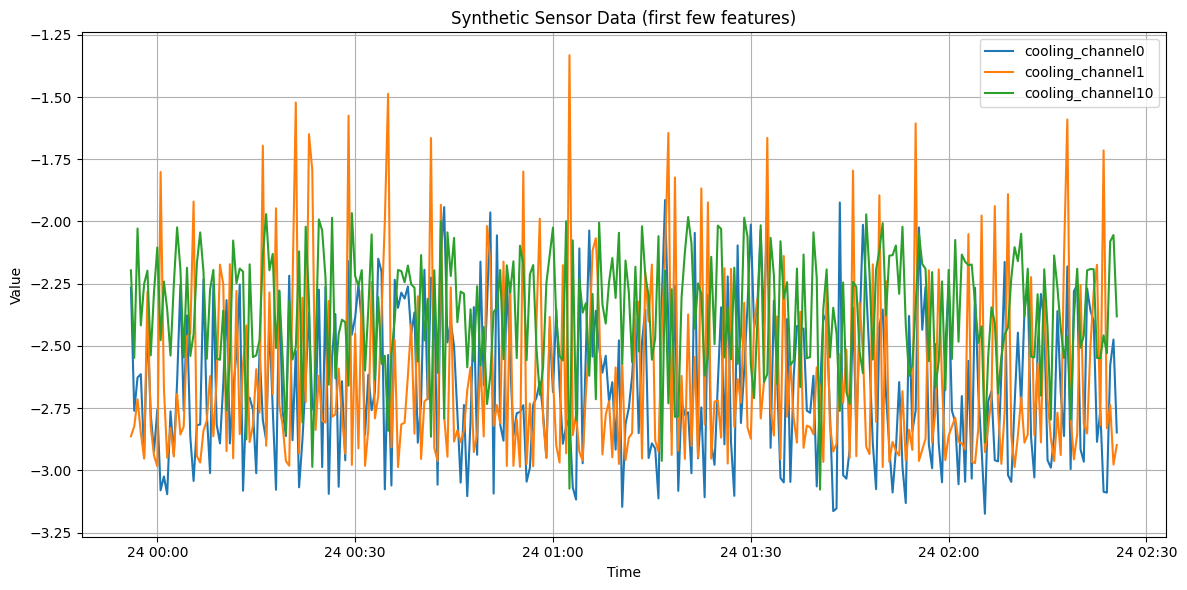

In [65]:
visualize_synthetic_data(synthetic_df, num_features=3, num_timesteps=300)

In [66]:
save_dir = "./saved_models_timegan_with_arima"
os.makedirs(save_dir, exist_ok=True)

timegan.generator.save_weights(os.path.join(save_dir, "generator.weights.h5"))
timegan.recovery.save_weights(os.path.join(save_dir, "recovery.weights.h5"))
timegan.supervisor.save_weights(os.path.join(save_dir, "supervisor.weights.h5"))
timegan.discriminator.save_weights(os.path.join(save_dir, "discriminator.weights.h5"))

print("All TimeGAN component weights saved.")

All TimeGAN component weights saved.


In [67]:
print("\nGenerator Structure:")
timegan.generator.summary()

print("\nRecovery Structure:")
timegan.recovery.summary()

print("\nSupervisor Structure:")
timegan.supervisor.summary()

print("\nDiscriminator Structure:")
timegan.discriminator.summary()


Generator Structure:


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_465 (InputLayer)    │ (None, 120, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_154 (SimpleRNN)      │ (None, 120, 16)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_308         │ (None, 120, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_308 (Dropout)           │ (None, 120, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_769 (Dense)               │ (None, 120, 16)        │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_770 (Dense)               │ (None, 120, 3)         │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 707 (2.76 KB)

 Trainable params: 675 (2.64 KB)

 Non-trainable params: 32 (128.00 B)


Recovery Structure:


Model: "Recovery"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)     │ (None, None, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_27 (GRU)                    │ (None, None, 64)       │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, None, 14)       │           910 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,270 (63.55 KB)

 Trainable params: 16,270 (63.55 KB)

 Non-trainable params: 0 (0.00 B)


Supervisor Structure:


Model: "Supervisor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)     │ (None, None, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, None, 64)       │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, None, 16)       │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, None, 14)       │           238 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,646 (100.18 KB)

 Trainable params: 25,646 (100.18 KB)

 Non-trainable params: 0 (0.00 B)


Discriminator Structure:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_53 (InputLayer)     │ (None, None, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_26 (GRU)                    │ (None, 64)             │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,673 (65.13 KB)

 Trainable params: 16,545 (64.63 KB)

 Non-trainable params: 128 (512.00 B)

## With Embedder and recovery

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import SimpleRNN, GRU, Dense, Dropout, BatchNormalization, LayerNormalization, TimeDistributed, Add
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from scipy import signal
import os

In [85]:
class ImprovedTimeGAN:
    def __init__(self, seq_len, n_features, latent_dim=32):
        self.seq_len = seq_len
        self.n_features = n_features
        self.latent_dim = latent_dim

        self.embedder = self._build_embedder()
        self.recovery = self._build_recovery()
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        self.supervisor = self._build_supervisor()

        self.metrics = {
            'gen_loss': [], 'disc_loss': [], 'sup_loss': [],
            'embed_loss': [], 'dtw_score': [], 'psd_diff': []
        }
        self.checkpoint_path = os.path.join("checkpoints", "best_model.weights.h5")
        os.makedirs("checkpoints", exist_ok=True)
        self.best_loss = float('inf')

    def _build_embedder(self):
        inputs = Input(shape=(None, self.n_features))
        x = SimpleRNN(32, return_sequences=True)(inputs)
        x = BatchNormalization()(x)
        x = GRU(32, return_sequences=True)(x)
        outputs = TimeDistributed(Dense(self.latent_dim))(x)
        return Model(inputs, outputs, name="Embedder")

    def _build_recovery(self):
        inputs = Input(shape=(None, self.latent_dim))
        x = GRU(64, return_sequences=True)(inputs)
        outputs = TimeDistributed(Dense(self.n_features))(x)
        return Model(inputs, outputs, name="Recovery")

    def _build_generator(self):
        inputs = Input(shape=(None, self.latent_dim))
        x = SimpleRNN(16, return_sequences=True, kernel_initializer='orthogonal')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(0.49)(x)
        x = Dense(16, activation='tanh')(x)
        outputs = TimeDistributed(Dense(self.latent_dim, activation='tanh', kernel_initializer='glorot_normal'))(x)
        return Model(inputs, outputs, name="Generator")

    def _build_discriminator(self):
        inputs = Input(shape=(None, self.latent_dim))
        x = GRU(64, return_sequences=False, kernel_initializer='glorot_uniform')(inputs)
        x = BatchNormalization()(x)
        x = Dropout(0.2267)(x)
        x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0033))(x)
        outputs = Dense(1, activation='sigmoid')(x)
        return Model(inputs, outputs, name="Discriminator")

    def _build_supervisor(self):
        inputs = Input(shape=(None, self.latent_dim))
        x = GRU(64, return_sequences=True)(inputs)
        x = GRU(16, return_sequences=True)(x)
        outputs = TimeDistributed(Dense(self.latent_dim))(x)
        return Model(inputs, outputs, name="Supervisor")

    def compile(self, lr=1.025e-5):
        self.gen_optimizer = Adam(lr)
        self.disc_optimizer = Adam(lr)
        self.sup_optimizer = Adam(lr)
        self.embed_optimizer = Adam(lr)
        self.bce_loss = tf.keras.losses.BinaryCrossentropy()
        self.mse_loss = tf.keras.losses.MeanSquaredError()

    def train(self, real_data, epochs=100, batch_size=64, patience=10):
        dataset = tf.data.Dataset.from_tensor_slices(real_data).shuffle(1000).batch(batch_size)
        patience_counter = 0
        for epoch in range(epochs):
            curr_seq_len = min(self.seq_len, 10 + epoch // 5)
            print(f"\nEpoch {epoch+1}/{epochs} - Training on {curr_seq_len} steps")
            progress_bar = tqdm(dataset, desc="Training")
            for step, batch in enumerate(progress_bar):
                batch = batch[:, :curr_seq_len, :]
                self._train_step(batch)
                progress_bar.set_postfix({
                    "Gen Loss": f"{self.metrics['gen_loss'][-1]:.4f}",
                    "Disc Loss": f"{self.metrics['disc_loss'][-1]:.4f}",
                    "Sup Loss": f"{self.metrics['sup_loss'][-1]:.4f}",
                    "Embed Loss": f"{self.metrics['embed_loss'][-1]:.4f}"
                })
            self._evaluate_metrics(real_data[:100])
            improved = self._save_checkpoint_if_best(epoch)
            if not improved:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} due to no improvement.")
                    break
                else:
                    patience_counter = 0

    def _train_step(self, real_sequences):
        with tf.GradientTape() as embed_tape:
            H = self.embedder(real_sequences, training=True)
            X_tilde = self.recovery(H, training=True)
            embed_loss = self.mse_loss(real_sequences, X_tilde)

        with tf.GradientTape(persistent=True) as gen_tape:
            E_hat = self.generator(H, training=True)
            H_hat = self.supervisor(E_hat, training=True)

            Y_real = self.discriminator(H, training=True)
            Y_fake = self.discriminator(H_hat, training=True)

            gen_loss = self.bce_loss(tf.ones_like(Y_fake), Y_fake)
            sup_loss = self.mse_loss(H[:, 1:], H_hat[:, :-1])
            fm_loss = tf.reduce_mean(tf.abs(tf.reduce_mean(Y_real, axis=0) - tf.reduce_mean(Y_fake, axis=0)))
            total_loss = gen_loss + 0.5 * sup_loss + 0.1 * fm_loss

        embed_grads = embed_tape.gradient(embed_loss, self.embedder.trainable_variables)
        self.embed_optimizer.apply_gradients(zip(embed_grads, self.embedder.trainable_variables))

        gen_grads = gen_tape.gradient(total_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))

        sup_grads = gen_tape.gradient(sup_loss, self.supervisor.trainable_variables)
        self.sup_optimizer.apply_gradients(zip(sup_grads, self.supervisor.trainable_variables))

        with tf.GradientTape() as disc_tape:
            Y_real_d = self.discriminator(H, training=True)
            Y_fake_d = self.discriminator(H_hat, training=True)
            disc_loss = 0.5 * (self.bce_loss(tf.ones_like(Y_real_d), Y_real_d) + self.bce_loss(tf.zeros_like(Y_fake_d), Y_fake_d))

        disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        self.metrics['gen_loss'].append(gen_loss.numpy())
        self.metrics['disc_loss'].append(disc_loss.numpy())
        self.metrics['sup_loss'].append(sup_loss.numpy())
        self.metrics['embed_loss'].append(embed_loss.numpy())

    def _evaluate_metrics(self, real_data):
        H = self.embedder(real_data)
        synthetic_data = self.recovery(self.generator(H))

        try:
            from dtaidistance import dtw
            dtw_scores = [
                dtw.distance(real_data[i].flatten(), synthetic_data[i].numpy().flatten())
                for i in range(min(10, len(real_data)))
            ]
            self.metrics['dtw_score'].append(np.mean(dtw_scores))
        except Exception as e:
            print("⚠️ DTW failed:", e)
            self.metrics['dtw_score'].append(0.0)

        real_flat = real_data[:10].flatten()
        synth_flat = synthetic_data[:10].numpy().flatten()

        f_real, Pxx_real = signal.welch(real_flat)
        f_synth, Pxx_synth = signal.welch(synth_flat)
        self.metrics['psd_diff'].append(np.mean(np.abs(Pxx_real - Pxx_synth)))

    def _print_metrics(self, epoch):
        print(f"\nMetrics after epoch {epoch+1}:")
        print(f"Generator Loss: {self.metrics['gen_loss'][-1]:.4f}")
        print(f"Discriminator Loss: {self.metrics['disc_loss'][-1]:.4f}")
        print(f"Supervisor Loss: {self.metrics['sup_loss'][-1]:.4f}")
        print(f"Embedding Loss: {self.metrics['embed_loss'][-1]:.4f}")
        print(f"DTW Score: {self.metrics['dtw_score'][-1]:.4f}")
        print(f"PSD Difference: {self.metrics['psd_diff'][-1]:.4f}")

    def _save_checkpoint_if_best(self, epoch):
        """Save model if it has improved; return True if improved, False otherwise"""
        current_loss = self.metrics['gen_loss'][-1]
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.generator.save_weights(self.checkpoint_path)
            print(f"Best model updated at epoch {epoch+1}, Gen Loss: {current_loss:.4f}")
            return True
        return False

    def _log_tensorboard(self, epoch):
        self.writer.add_scalar("Loss/Generator", self.metrics['gen_loss'][-1], epoch)
        self.writer.add_scalar("Loss/Discriminator", self.metrics['disc_loss'][-1], epoch)
        self.writer.add_scalar("Loss/Supervisor", self.metrics['sup_loss'][-1], epoch)
        self.writer.add_scalar("Loss/Embedder", self.metrics['embed_loss'][-1], epoch)
        self.writer.add_scalar("Metric/DTW", self.metrics['dtw_score'][-1], epoch)
        self.writer.add_scalar("Metric/PSD", self.metrics['psd_diff'][-1], epoch)


        plt.figure(figsize=(15, 10))
        plt.subplot(2, 2, 1)
        plt.plot(self.metrics['gen_loss'], label='Generator')
        plt.plot(self.metrics['disc_loss'], label='Discriminator')
        plt.title('Adversarial Training Loss')
        plt.legend()
        plt.subplot(2, 2, 2)
        plt.plot(self.metrics['sup_loss'], label='Supervisor')
        plt.plot(self.metrics['embed_loss'], label='Embedder')
        plt.title('Auxiliary Losses')
        plt.legend()
        plt.subplot(2, 2, 3)
        plt.plot(self.metrics['dtw_score'])
        plt.title('DTW Score (Lower is Better)')
        plt.subplot(2, 2, 4)
        plt.plot(self.metrics['psd_diff'])
        plt.title('PSD Difference (Lower is Better)')
        plt.tight_layout()
        plt.show()
        
    def plot_training_history(self):
        plt.figure(figsize=(14, 5))

        # Plot generator & supervisor loss
        plt.subplot(1, 3, 1)
        plt.plot(self.metrics['gen_loss'], label='Generator Loss')
        plt.plot(self.metrics['sup_loss'], label='Supervisor Loss')
        plt.title('Generator & Supervisor Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot discriminator loss
        plt.subplot(1, 3, 2)
        plt.plot(self.metrics['disc_loss'], label='Discriminator Loss', color='orange')
        plt.title('Discriminator Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot discriminator accuracy
        plt.subplot(1, 3, 3)
        plt.plot(self.metrics['embed_loss'], label='Embedding Loss', color='green')
        plt.title('Embedding Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [86]:
import os
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.callbacks import ModelCheckpoint

In [89]:
class HybridARIMAGenerator:
    def __init__(self, timegan_model, save_dir='saved_hybrid_models'):
        self.timegan = timegan_model
        self.arima_models = []
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        
        # Track best model metrics
        self.best_metrics = {
            'arima_aic': float('inf'),
            'gan_loss': float('inf')
        }

    # def fit_arima(self, real_data, order=(1,0,1)):
    #     """Train ARIMA models with rolling window and save best models"""
    #     print("Training ARIMA models with rolling windows...")
    #     window_size = self.timegan.seq_len
    #     best_models_dir = os.path.join(self.save_dir, 'best_arima')
    #     os.makedirs(best_models_dir, exist_ok=True)
        
    #     for i in range(real_data.shape[-1]):
    #         feature_series = pd.Series(real_data[:, i])
    #         models = []
    #         best_model = None
            
    #         for j in tqdm(range(len(feature_series) - window_size), 
    #                      desc=f"Feature {i+1}/{real_data.shape[-1]}"):
    #             window = feature_series.iloc[j:j+window_size]
    #             try:
    #                 model = ARIMA(window, order=order).fit()
    #                 models.append(model)
                    
    #                 # Track best model for this feature
    #                 if model.aic < self.best_metrics['arima_aic']:
    #                     self.best_metrics['arima_aic'] = model.aic
    #                     best_model = model
    #                     # Save best ARIMA model for this feature
    #                     joblib.dump(model, 
    #                                os.path.join(best_models_dir, f'best_arima_feature_{i}.pkl'))
                        
    #             except Exception as e:
    #                 models.append(None)
    #                 print(f"ARIMA failed for window {j}: {str(e)}")
            
    #         self.arima_models.append(models)

    def fit_arima(self, real_data, order=(1, 0, 1)):
            print("Fitting one ARIMA model per feature...")
            window_size = self.timegan.seq_len
            self.arima_models = []

            for i in range(real_data.shape[-1]):
                print(f"  Fitting ARIMA for feature {i+1}/{real_data.shape[-1]}...")
                series = pd.Series(real_data[-window_size:, i])

                try:
                    model = ARIMA(series, order=order).fit()
                    joblib.dump(model, os.path.join(self.save_dir, f'best_arima_feature_{i}.pkl'))
                    self.arima_models.append([model])
                    print(f"    AIC: {model.aic:.2f}")
                    del model
                    gc.collect()
                except Exception as e:
                    print(f"    ERROR fitting ARIMA for feature {i}: {e}")
                    self.arima_models.append([None])

    def generate_hybrid_samples(self, n_samples=100):
        """Generate hybrid samples using best saved models"""
        print("\nGenerating hybrid samples...")
        synthetic_samples = []
        
        # Load best ARIMA models if available
        best_models_dir = os.path.join(self.save_dir, 'best_arima')
        if os.path.exists(best_models_dir):
            print("Loading best ARIMA models...")
            best_arima_models = []
            for i in range(len(self.arima_models)):
                model_path = os.path.join(best_models_dir, f'best_arima_feature_{i}.pkl')
                if os.path.exists(model_path):
                    best_arima_models.append(joblib.load(model_path))
                else:
                    best_arima_models.append(None)
        else:
            best_arima_models = None

        for _ in tqdm(range(n_samples)):
            arima_series = []
            for i, models in enumerate(self.arima_models):
                # Try to use best model first
                if best_arima_models and best_arima_models[i] is not None:
                    model = best_arima_models[i]
                else:
                    valid_models = [m for m in models if m is not None]
                    if not valid_models:
                        arima_series.append(np.zeros((self.timegan.seq_len,)))
                        continue
                    model = np.random.choice(valid_models)
                
                forecast = model.forecast(steps=self.timegan.seq_len)
                arima_series.append(forecast.values)
            
            arima_series = np.stack(arima_series, axis=1)
            noise = np.random.normal(size=(1, self.timegan.seq_len, self.timegan.latent_dim))
            
            # Generate GAN residuals
            gan_residuals = self.timegan.recovery(self.timegan.generator(noise)).numpy()[0]
            
            # Combine components with learned weights
            synthetic = arima_series * 0.7 + gan_residuals * 0.3
            synthetic_samples.append(synthetic)
        
        return np.array(synthetic_samples)

    def save_best_timegan(self, timegan, current_loss):
        """Save TimeGAN model if it's the best so far"""
        if current_loss < self.best_metrics['gan_loss']:
            self.best_metrics['gan_loss'] = current_loss
            timegan_path = os.path.join(self.save_dir, 'best_timegan')
            timegan.save_weights(timegan_path)
            print(f"\nNew best TimeGAN model saved (loss: {current_loss:.4f})")

In [ ]:
if __name__ == "__main__":
    # Load preprocessed data
    data_scaled, columns, scaler, time_col = load_and_preprocess_data(
        "../databases/processed_data/TimeGAN_data.csv",
        feature_range=(-1, 1)
    )

    # Prepare training sequences
    seq_len = 60
    sequences = np.array([
        data_scaled[i:i+seq_len]
        for i in range(len(data_scaled) - seq_len + 1)
    ])

    # Train ImprovedTimeGAN
    timegan = ImprovedTimeGAN(seq_len=seq_len, n_features=len(columns))
    timegan.compile(lr=0.0002)
    timegan.train(sequences, epochs=1, batch_size=32)
    timegan.plot_training_history()

    # Fit ARIMA
    hybrid_gen = HybridARIMAGenerator(timegan)
    hybrid_gen.fit_arima(data_scaled)

    # Generate synthetic data
    synthetic_data = hybrid_gen.generate_hybrid_samples(1000)
    synthetic_original_scale = scaler.inverse_transform(
        synthetic_data.reshape(-1, len(columns)))

    # Optional: save time column if exists
    synthetic_df = pd.DataFrame(synthetic_original_scale, columns=columns)
    if time_col is not None:
        synthetic_df.insert(0, time_col.name, pd.date_range(
            start=time_col.iloc[-1],
            periods=len(synthetic_df),
            freq=pd.infer_freq(time_col) if len(time_col) > 1 else 'D'
        ))

    # Save to CSV
    synthetic_df.to_csv('../databases/synthetic_data/imoroved_hybrid_synthetic_data.csv', index=False)
    print("Synthetic data saved.")

    # Save model
    final_save_path = os.path.join(hybrid_gen.save_dir, 'final_hybrid_model.h5')
    timegan.save_weights(final_save_path)
    print(f"Final TimeGAN model saved at {final_save_path}")


Epoch 1/1 - Training on 10 steps


Training:  50%|█████     | 1088/2158 [04:03<03:53,  4.57it/s, Gen Loss=2.6190, Disc Loss=0.0810, Sup Loss=0.0271, Embed Loss=0.0293]